# DS1000Z Rigol Waveform Examples

**Scott Prahl**

**March 2021**

The goal of this notebook was to figure out the origins of the raw data to voltage conversion on the Rigol 1000Z oscilloscope `.wfm` files and also validate the conversion against `.csv` files.  Unfortunately interpretation of files created by this family of scopes is still problematic.

*If RigolWFM is not installed, uncomment the following cell (i.e., delete the #) and run (shift-enter)*

In [1]:
#!pip install --user RigolWFM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    import RigolWFM.wfm as rigol
except ModuleNotFoundError:
    print('RigolWFM not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

repo = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/"

## Honestly, the Rigol firmware for these scopes is a disaster

This should be a trival conversion.  The scope stores a series of byte values and there is a scale and offset to convert these to volts.  Now for every other Rigol oscilloscope the conversion is

```
    volts = (raw-127)*scale - offset
```

At least two other people [@michal-szkutnik](https://github.com/michal-szkutnik/pyRigolWfm1000Z) and [@crasu](https://github.com/michal-szkutnik/pyRigolWfm1000Z/issues/3#issue-196373027) have tried to sort this out without apparent success.

So what is the story?  Rigol has gone through a [series of firmware revisions]( https://www.rigolna.com/firmware/) and things are still not right with the lastest version.

The current status is that the voltage scale seems to be pretty close to correct as long as the scale factor is calculated by
```
    scale = volt_per_division/20
```

The offset seems to be completely arbitrary.  **Consequently, if you want to use converted .wfm data, validate it against your own measurement first!** 

The list of Rigol scopes that probably suffer from the same firmware problems are: DS1074Z-S, DS1104Z, DS1104Z-S, DS1054Z, MSO1054Z, DS1074Z, MSO1074Z, MSO1104Z and the DS1202Z.

In [3]:
# Just a couple of handy functions to simplify making comparison graphs.

def plot_compare_one(w, csv_times, csv_data, chno):

    if chno-1 >= len(w.channels):
        return

    if chno >= len(csv_data):
        return

    ch = w.channels[chno-1]

    if not ch.enabled:
        return

    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

    name=w.basename

    plt.title("CH%d: %.3fV/div, %.2fVoff (%s %s) "% (chno,ch.volt_per_division,ch.volt_offset,name, w.firmware))

    plt.plot(csv_times, csv_data[chno], color='green', label='CSV')
    plt.plot(ch.times, ch.volts, color='red', label='WFM')
    plt.xlabel("Time (s)")
    plt.ylabel("Volts")
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.axhline(0,color='black',linestyle=':')

    plt.show()

def plot_compare(w, csv_times, csv_data, toffset=0):
    for i in [1,2,3,4]:
        plot_compare_one(w, csv_times-toffset, csv_data, i)

def scale_plot(w,csv_times,csv_data,chno,scale,v_offset,csv_h_offset,half_ns):
    
    if chno-1 >= len(w.channels):
        return

    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

    ch=w.channels[chno-1]
    v = ch.volts*scale+v_offset
    vmax = max(v)
    vmin = min(v)
    diff = vmax - vmin
    plt.plot(ch.times*1e9,v,label="$\Delta$V=%.2f (WFM)"%(diff))

    if chno < len(csv_data):
        v=csv_data[chno]
        vmax = max(v)
        vmin = min(v)
        diff = vmax - vmin
        plt.plot(csv_times*1e9+csv_h_offset,v,label="$\Delta$V=%.2f (CSV)"%(diff))

    name=w.basename
    plt.legend(loc="upper right")
    plt.title("CH%d, %.2fV/div %.2fVoff (%s %s)" % (chno, ch.volt_per_division, ch.volt_offset, name, w.firmware))
    plt.xlim(-half_ns,half_ns)
    plt.axhline(0,color='black',linestyle=':')
    plt.show()

#    print("       volt/division = %.4f" % (ch.volt_per_division))
#    print("  (volt/division)/20 = %.4f" % (ch.volt_per_division/20.0))
#    print("             y_scale = %.4f" % (ch.y_scale))
#    print("     %.3f * y_scale = %.4f (actual value)" % (scale, ch.y_scale*scale))
#    print("(volt/division)/21.0 = %.4f" % (-ch.volt_per_division/21))

A list of Rigol scopes in the DS1000Z family is:

In [4]:
print(rigol.DS1000Z_scopes)

['Z', '1000Z', 'DS1000Z', 'DS1202Z', 'DS1054Z', 'MSO1054Z', 'DS1074Z', 'MSO1074Z', 'DS1074Z-S', 'DS1104Z', 'MSO1104Z', 'DS1104Z-S']


## Background on the voltage and time conversions.

It is bit confusing because the `.wfm` files and the `.csv` files can differ.  I think that the `.wfm` files always correspond to the scope's `RAW` mode and the `.csv` files can be limited to just the display or `NORMAL` mode.

### Voltage conversion

From the [Rigol Programming Guide](https://www.batronix.com/pdf/Rigol/ProgrammingGuide/MSO1000Z_DS1000Z_ProgrammingGuide_EN.pdf)
    
page 2-221::
>    volts = (raw_byte - YORigin - YREFerence) * YINCrement

page 2-223, assuming `RAW` mode::
>    YINCrement = VerticalScale/25

>    YORigin = VerticalOffset/YINCrement

>    YREFerence is always 127
    
So this becomes::
>    volts = (raw_byte - VerticalOffset/YINCrement - 127) * YINCrement

>    volts = (raw_byte - 127) * YINCrement - VerticalOffset

>    volts = (raw_byte - 127) * VerticalScale/25 - VerticalOffset

and this can be interpreted as

>    volts = (raw_byte - 127.0) * VoltsPerDivision/25.0 - VerticalOffset

Where the decimal points are needed to force python avoid integer math.

Now based on actually comparing DS1054Z `.wfm` data with `.csv` data, the above equation fails.  This is unfortunate because this is the equation used all other Rigol scopes.  Instead the equation is something like

>    volts = (raw_byte - 127) * (-VerticalScale/20) - VerticalOffset + VerticalScale

Gaak.

### Time Conversions

On page 2-222 we find that

`XINCrement` the time difference between two neighboring points of the specified channel source in the X direction and

> XINCrement = 1/SampleRate

on the other hand, when the scope is in `NORMAL` mode or display mode, then

> XINCrement = TimeScale/100

`XORigin` is the start time of the waveform data of the channel source currently selected in the X direction.

Both should be in seconds.

### CSV Files

#### Display saving

It seems that the time parameters provided in the `.csv` file (when saving the `display` points) is set so the center point is at time zero.  There are twelve divisions that are saved and each division has 100 points.  Therefore the time increment is given by

> time_increment = time_per_division/100

and the start time is

> -600 * time_increment

(There is probably an time offset also ...)

## Start with waveform with a single trace

[Contributed by @JBR48](https://github.com/michal-szkutnik/pyRigolWfm1000Z/issues/1#issuecomment-212646090)

First let's look at the description of the internal file structure. We see that only channel 1 has been enabled.  Unfortunately, there is not an accompanying `.csv` file so we cannot do much more than verify that the file is parsed and displays a plausible 5kHz sine wave.

In [5]:
# raw=true is needed because this is a binary file
wfm_url = repo + "MSO1104.wfm" + "?raw=true"  

w = rigol.Wfm.from_url(wfm_url, '1000Z')

description = w.describe()
print(description)

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/MSO1104.wfm?raw=true'
    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = 00.04.03.SP2
        Filename     = MSO1104.wfm
        Channels     = [1]

     Channel 1:
         Coupling =       AC
            Scale =     5.00  V/div
           Offset =   400.00 mV
            Probe =      10X
         Inverted =    False

        Time Base =    1.000 ms/div
           Offset = -200.000 ps
            Delta = 1000.000 ns/point
           Points =  1200512

         Count    = [        1,        2,        3  ...   1200511,  1200512]
           Raw    = [      174,      175,      176  ...        70,       70]
           Times  = [-600.256 ms,-600.255 ms,-600.254 ms  ... 600.255 ms,600.256 ms]
           Volts  = [ 16.35  V, 16.60  V, 16.85  V  ...  -9.65  V, -9.65  V]




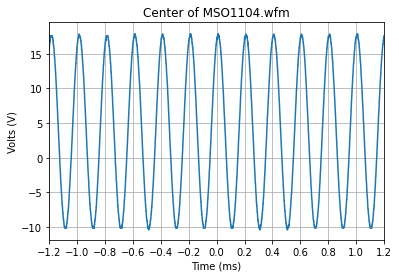

In [6]:
ch = w.channels[0]
plt.plot(ch.times*1e3-0.04, ch.volts)
plt.xlabel("Time (ms)")
plt.ylabel("Volts (V)")
plt.xlim(-1.2,1.2)
plt.title("Center of MSO1104.wfm")
plt.xticks(np.linspace(-1.2,1.2,13))
plt.grid(True)
plt.show()

## DS1074Z-A Scope file

[Contributed by @ro-bercik](https://github.com/michal-szkutnik/pyRigolWfm1000Z/issues/4#issue-361649641)

Note that this file uses old 04.04.SP3 firmware and both the offset and scaling is a bit off.  Specifically, it looks like the scaling factor (usually, volts_per_division/20) is (usually, volts_per_division/21).

<img src="https://user-images.githubusercontent.com/43404500/45744052-0b897080-bbed-11e8-8d96-d46fd7e4c9c7.png" width="50%">

In [7]:
name = "DS1074Z-A"
wfm_url = repo + name + ".wfm" + "?raw=true"  
w = rigol.Wfm.from_url(wfm_url, '1000Z')

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.wfm?raw=true'


In [8]:
csv_filename = repo + name + ".csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2)
csv_data = csv_data[:,:-1].T

t_incr = 2.000000e-05    # seconds/point
t_start = -len(csv_data[0])/2.0 * t_incr    # seconds so that t=0 is in the center
csv_times = csv_data[0] * t_incr + t_start   # seconds

print(w.describe())

    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = 00.04.04.SP3
        Filename     = DS1074Z-A.wfm
        Channels     = [1, 2, 3]

     Channel 1:
         Coupling =       AC
            Scale =    50.00 mV/div
           Offset =     0.00  V
            Probe =       1X
         Inverted =    False

        Time Base =    2.000 ms/div
           Offset =   10.000 ms
            Delta =    8.000 ns/point
           Points =  3000128

         Count    = [        1,        2,        3  ...   3000127,  3000128]
           Raw    = [      115,      115,      115  ...       140,      140]
           Times  = [-2.001 ms,-2.001 ms,-2.000 ms  ... 22.001 ms,22.001 ms]
           Volts  = [ 20.00 mV, 20.00 mV, 20.00 mV  ...  82.50 mV, 82.50 mV]

     Channel 2:
         Coupling =       AC
            Scale =   500.00 mV/div
           Offset =     0.00  V
            Probe =       1X
         Inverted =    False

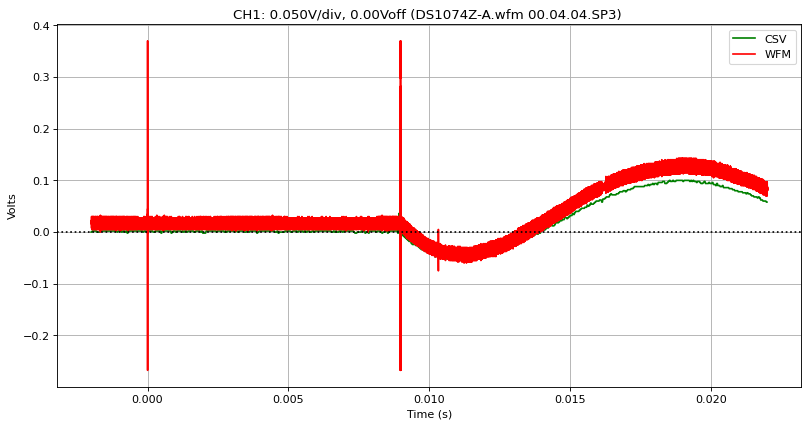

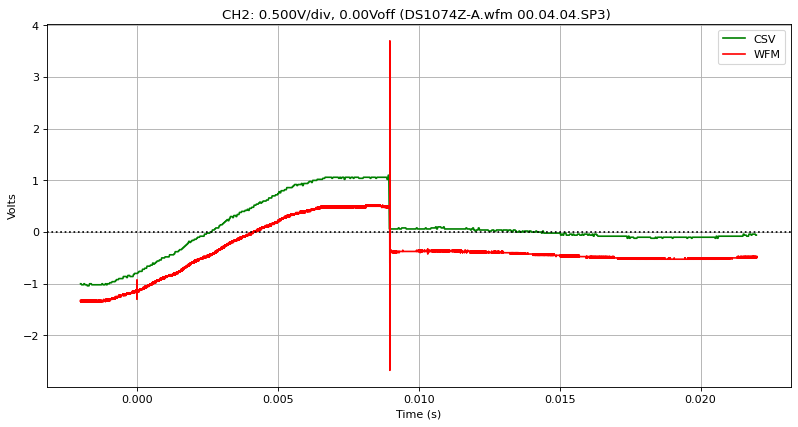

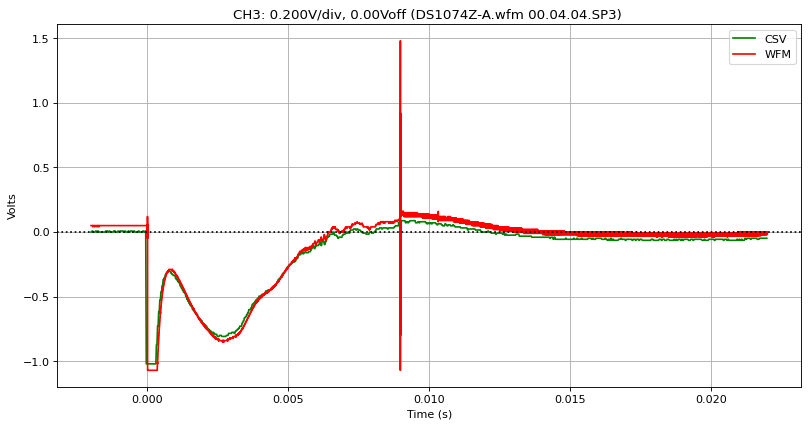

In [9]:
plot_compare(w, csv_times, csv_data, -0.01)

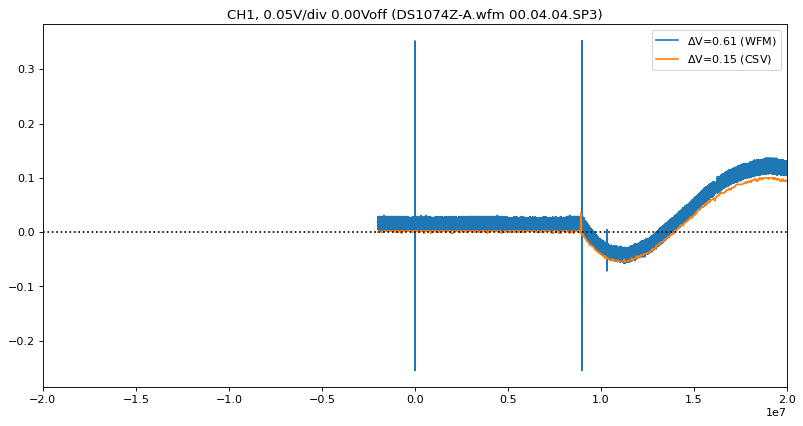

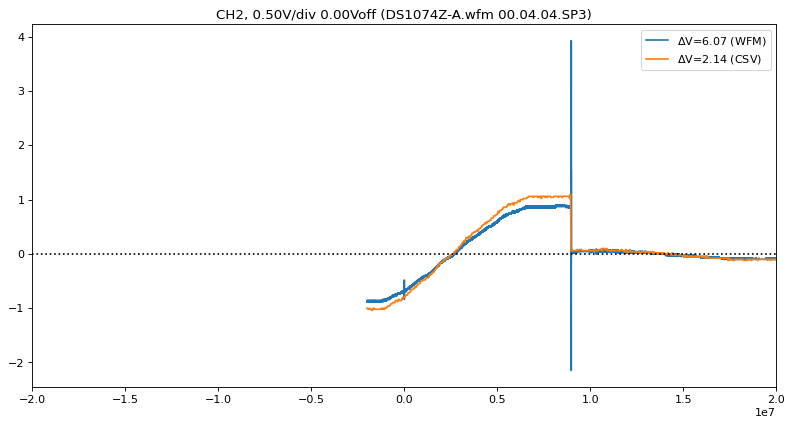

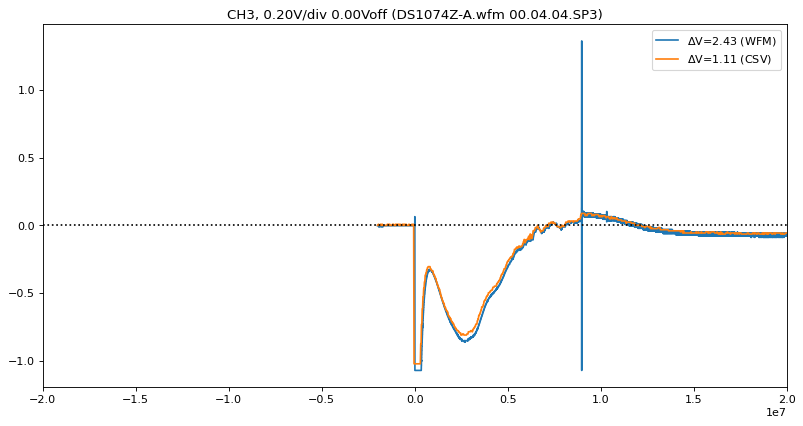

In [10]:
scale=0.952
end_ns=20000000
scale_plot(w,csv_times,csv_data,1,scale,0.0,end_ns/2,end_ns)
scale_plot(w,csv_times,csv_data,2,scale,0.4,end_ns/2,end_ns)
scale_plot(w,csv_times,csv_data,3,scale,-0.05,end_ns/2,end_ns)

## DS1054Z-A Scope file

[Contributed by @JensRestemeier](https://github.com/scottprahl/RigolWFM/issues/5#issuecomment-599158528)

In [11]:
name = "DS1054Z-A"
wfm_url = repo + name + ".wfm" + "?raw=true"  
w = rigol.Wfm.from_url(wfm_url, '1000Z')

csv_filename = repo + name + ".csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2)
csv_data = csv_data[:,:-1].T


t_incr = 5.000000e-10    # seconds/point
t_start = -len(csv_data[0])/2.0 * t_incr    # seconds so that t=0 is in the center
csv_times = csv_data[0] * t_incr + t_start   # seconds
print(w.describe())

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-A.wfm?raw=true'
    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = 00.04.04.SP4
        Filename     = DS1054Z-A.wfm
        Channels     = [1, 2, 3, 4]

     Channel 1:
         Coupling =       DC
            Scale =     2.00  V/div
           Offset =     3.00  V
            Probe =      10X
         Inverted =    False

        Time Base =   50.000 ns/div
           Offset =    0.000  s
            Delta =    4.000 ns/point
           Points =      278

         Count    = [        1,        2,        3  ...       277,      278]
           Raw    = [      158,      157,      159  ...       176,      176]
           Times  = [-556.000 ns,-551.986 ns,-547.971 ns  ... 551.986 ns,556.000 ns]
           Volts  = [  2.10  V,  2.00  V,  2.20  V  ...   3.90  V,  3.90  V]

     Channel 2:
         Coupling =       DC
            Scale =    

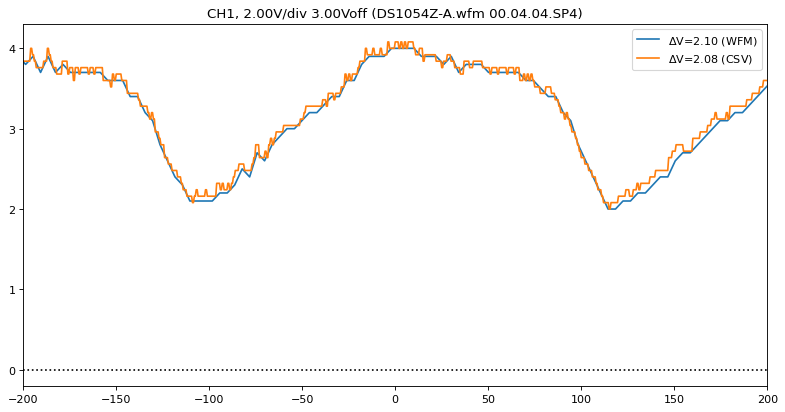

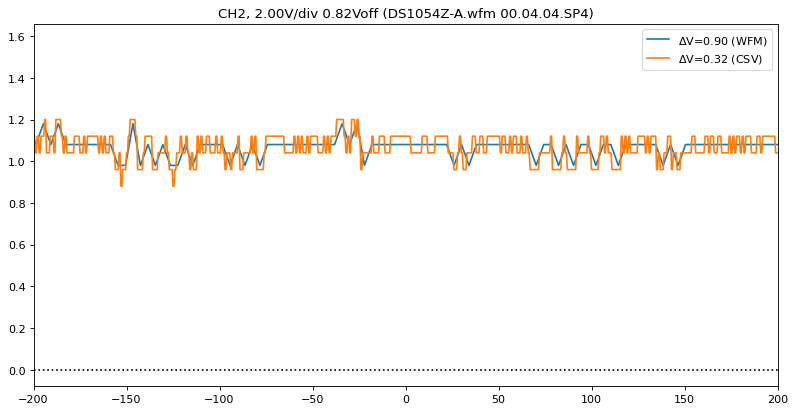

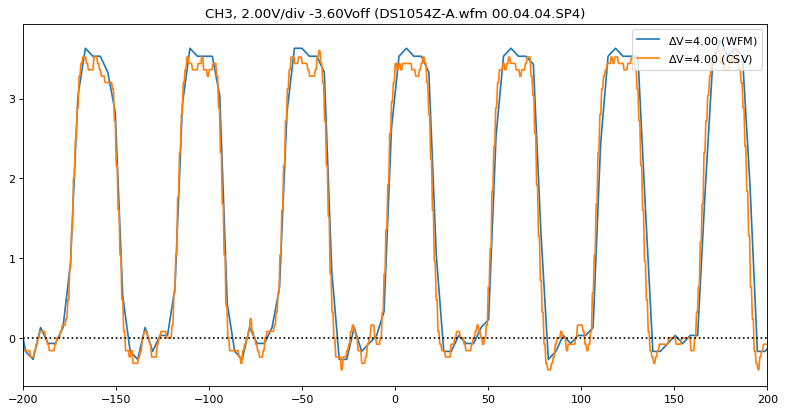

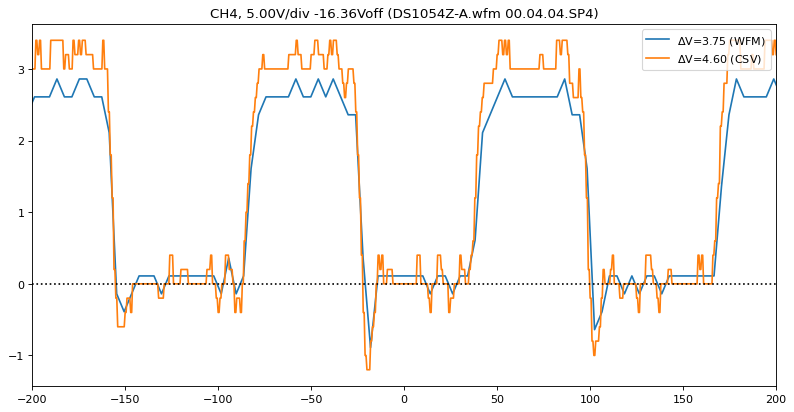

In [12]:
scale=1
end_ns=200
offset_ns=-62
scale_plot(w,csv_times,csv_data,1,scale,0.0,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,2,scale,0.2,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,3,scale,0.33,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,4,scale,3,offset_ns,end_ns)

## DS1054Z-B Scope file

[Contributed by @JensRestemeier](https://github.com/scottprahl/RigolWFM/issues/5#issuecomment-599210113)

<img src="https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-B.png" width="100%">

In [13]:
name = "DS1054Z-B"
wfm_url = repo + name + ".wfm" + "?raw=true"  
w = rigol.Wfm.from_url(wfm_url, '1000Z')

csv_filename = repo + name + ".csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2)
csv_data = csv_data[:,:-1].T

t_incr = 4.000000e-9    # seconds/point
t_start = -len(csv_data[0])/2.0 * t_incr    # seconds so that t=0 is in the center
csv_times = csv_data[0] * t_incr + t_start   # seconds

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-B.wfm?raw=true'


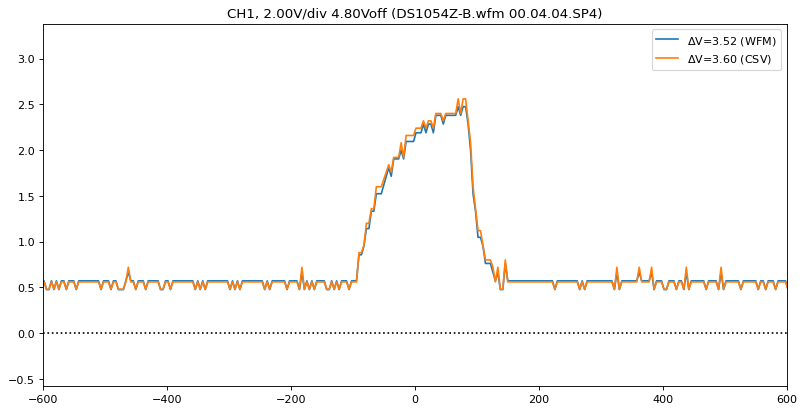

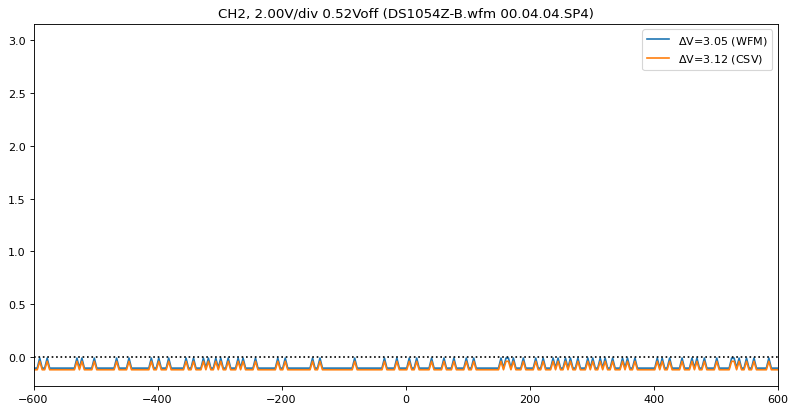

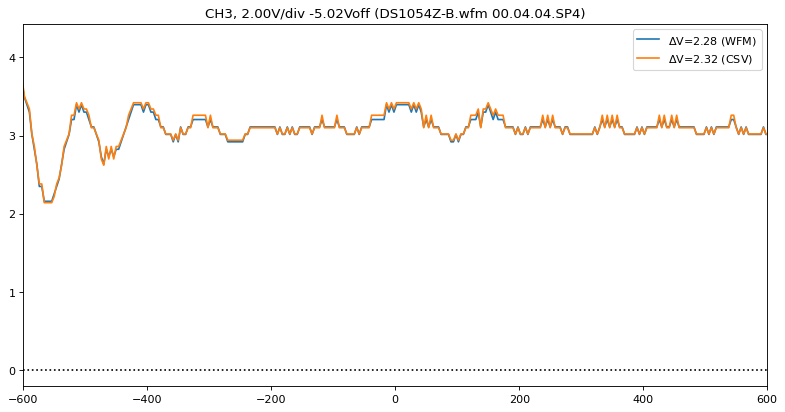

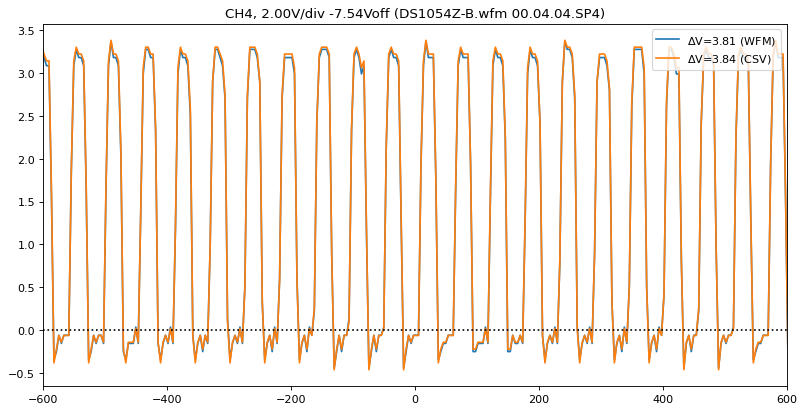

In [14]:
scale=0.952
end_ns=600
offset_ns=918
scale_plot(w,csv_times,csv_data,1,scale,0.0,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,2,scale,0.2,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,3,scale,0.33,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,4,scale,0.38,offset_ns,end_ns)

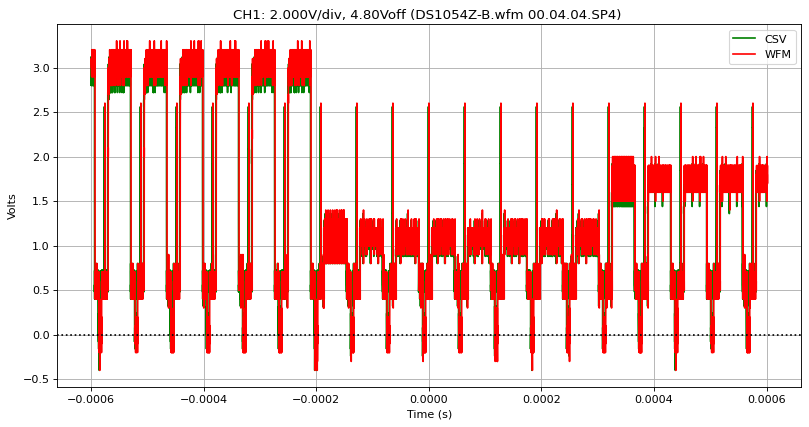

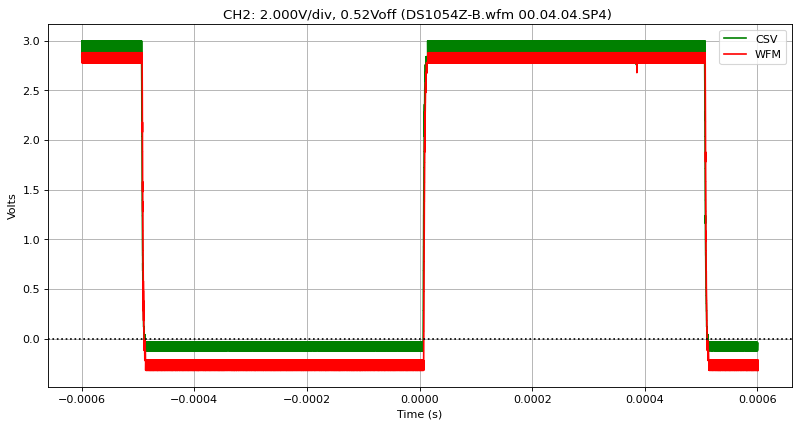

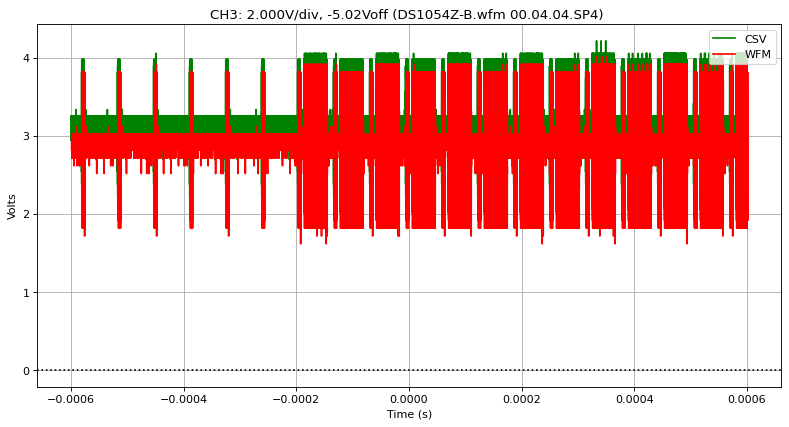

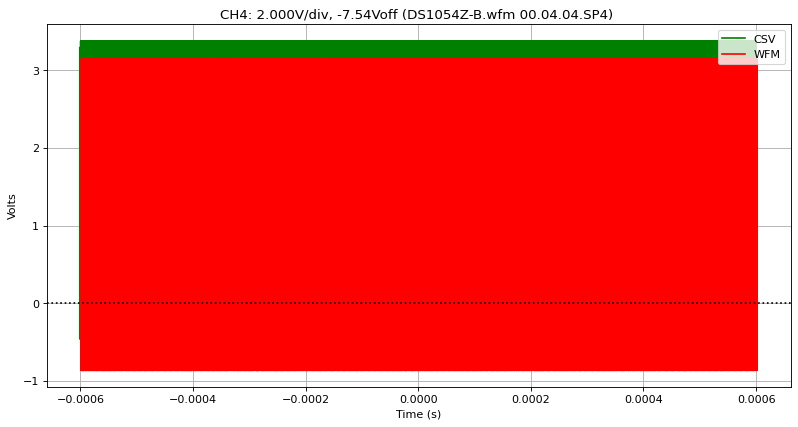

In [15]:
plot_compare(w, csv_times, csv_data, 0)

## DS1054Z-C Scope file

[Contributed by @electronoob.](https://github.com/scottprahl/RigolWFM/issues/5#issuecomment-600314960)

<img src="https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-C.png" width="100%">

In [16]:
name = "DS1054Z-C"
wfm_url = repo + name + ".wfm" + "?raw=true"  
w = rigol.Wfm.from_url(wfm_url, '1000Z')

csv_filename = repo + name + ".csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2)
csv_data = csv_data[:,:-1].T

# this .csv file has the last 250000 points removed
t_incr = 4.000000e-9    # seconds/point
t_start = -len(csv_data[0])/2.0 * t_incr    # seconds so that t=0 is in the center
csv_times = csv_data[0] * t_incr + t_start   # seconds

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-C.wfm?raw=true'


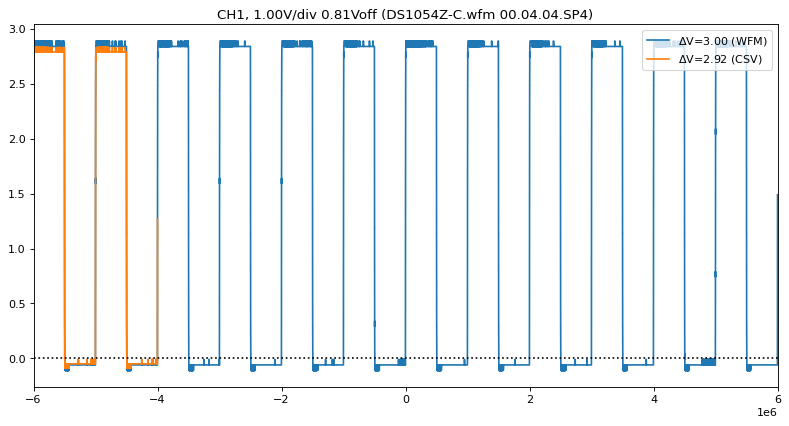

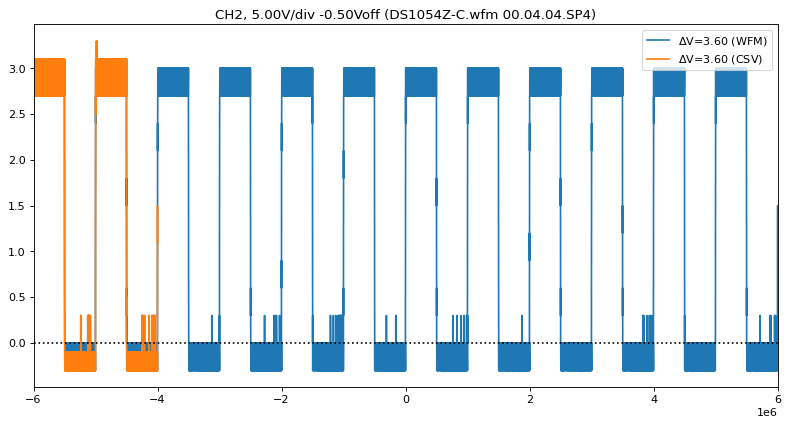

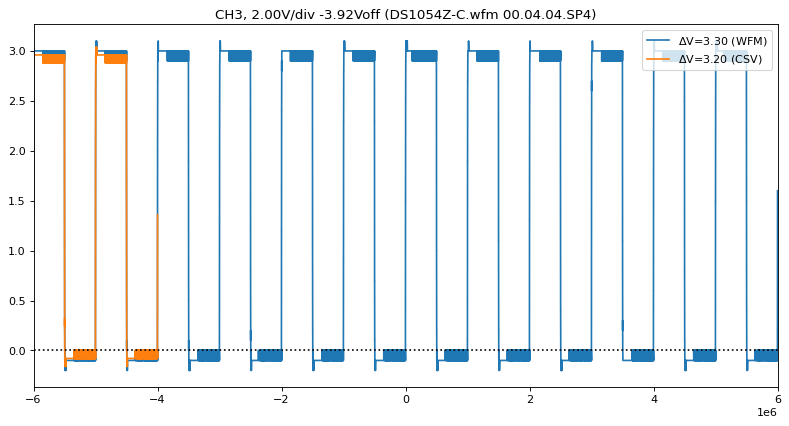

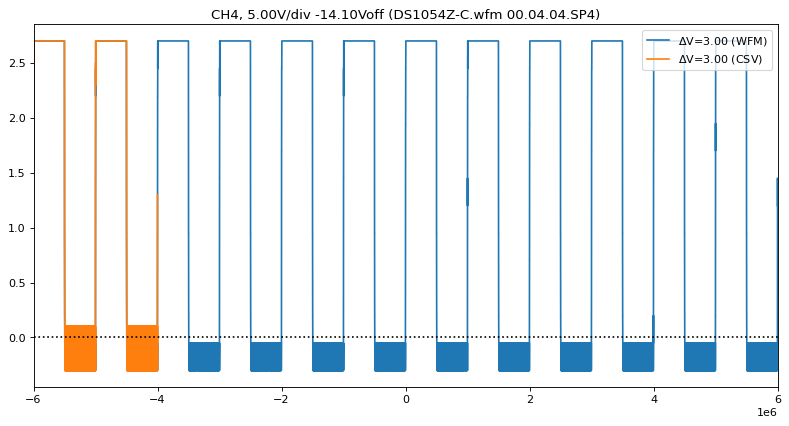

In [17]:
scale=1
end_ns=6000000
offset_ns=-77-5000000
scale_plot(w,csv_times,csv_data,1,scale,0.1,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,2,scale*1.2,7.2,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,3,scale,0.38,offset_ns,end_ns)
scale_plot(w,csv_times,csv_data,4,scale,1.1,offset_ns,end_ns)

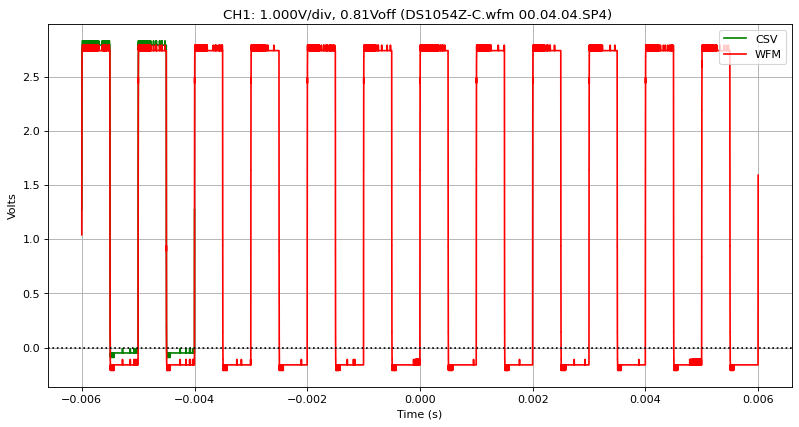

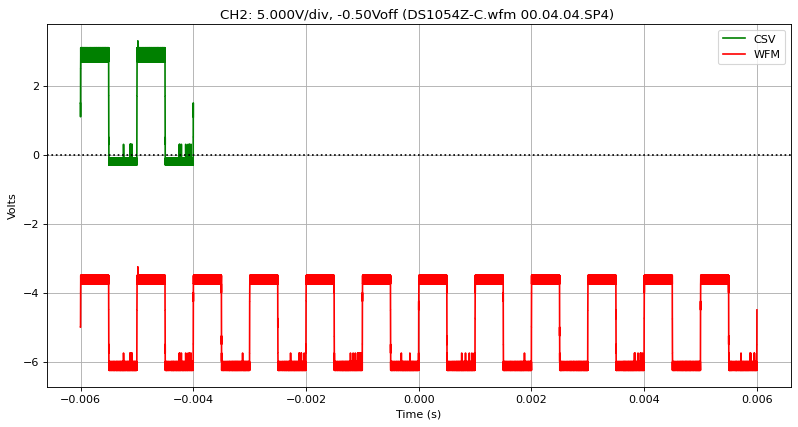

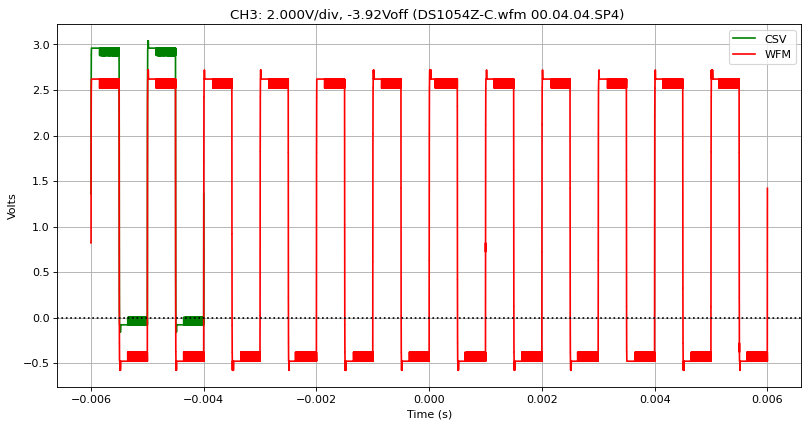

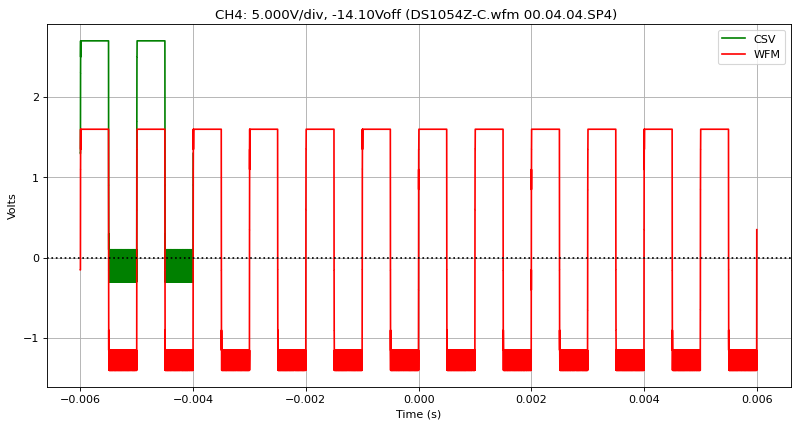

In [18]:
plot_compare(w, csv_times, csv_data, 0.005)

## DS1054Z-D Scope file

[Contributed by @JensRestemeier](https://github.com/scottprahl/RigolWFM/issues/5#issuecomment-602181223)

<img src="https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-D.png" width="100%">

In [19]:
name = "DS1054Z-D"
wfm_url = repo + name + ".wfm" + "?raw=true"  
w = rigol.Wfm.from_url(wfm_url, '1000Z')

csv_filename = repo + name + ".csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2)
csv_data = csv_data[:,:-1].T

t_incr = 4.000000e-9    # seconds/point
t_start = -len(csv_data[0])/2.0 * t_incr    # seconds so that t=0 is in the center
csv_times = csv_data[0] * t_incr + t_start   # seconds

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-D.wfm?raw=true'


In [20]:
print(w.describe())

    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = 00.04.04.SP4
        Filename     = DS1054Z-D.wfm
        Channels     = [1, 2, 3, 4]

     Channel 1:
         Coupling =       DC
            Scale =     5.00  V/div
           Offset =    11.25  V
            Probe =      10X
         Inverted =    False

        Time Base =  500.000 µs/div
           Offset = -220.000 µs
            Delta =    4.000 ns/point
           Points =  1500128

         Count    = [        1,        2,        3  ...   1500127,  1500128]
           Raw    = [      121,      120,      121  ...       121,      121]
           Times  = [-3.220 ms,-3.220 ms,-3.220 ms  ...  2.780 ms, 2.780 ms]
           Volts  = [ -7.75  V, -8.00  V, -7.75  V  ...  -7.75  V, -7.75  V]

     Channel 2:
         Coupling =       DC
            Scale =     1.00  V/div
           Offset =   940.00 mV
            Probe =      10X
         Inverted =    Fa

In [21]:
plot_compare(w, csv_times, csv_data, toffset=0)

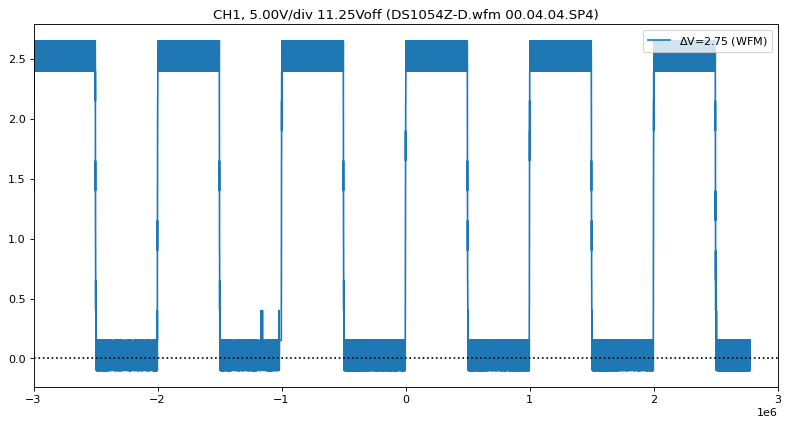

In [22]:
scale=1.0
end_ns=3000000
offset_ns=-220100

scale_plot(w,csv_times,csv_data,1,scale,7.9,offset_ns,end_ns)


## Summarizing all the results

It is not pretty.  If there was anything consistent, then it is not apparent to me!

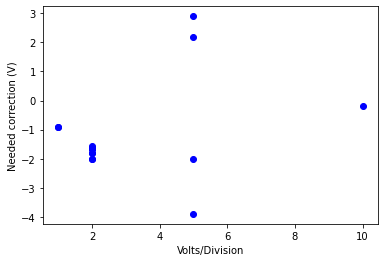

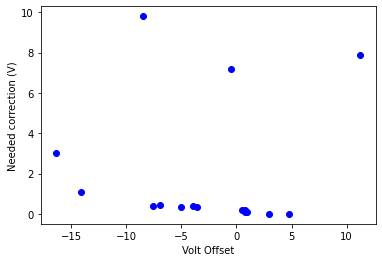

In [23]:
vd = np.array([2,2,2,5,2,2,2,2,1,5,2,5,5,1,10,2])
voff = np.array([3,0.82,-3.6,-16.36,4.8,0.52,-5.02,-7.54,0.81,-0.5,-3.92,-14.1,11.25,0.94,-8.5,-6.94])
yoff = voff-vd
vcorrect = np.array([0,0.2,0.33,3,0,0.2,0.33,0.38,0.1,7.2,0.38,1.1,7.9,0.1,9.8,0.45])
plt.plot(vd,vcorrect-vd,'ob')
plt.xlabel('Volts/Division')
plt.ylabel('Needed correction (V)')
plt.show()

plt.plot(voff,vcorrect,'ob')
plt.xlabel('Volt Offset')
plt.ylabel('Needed correction (V)')
plt.show()

## Testing channel selection

In [24]:
name = "DS1054Z-A"
wfm_url = repo + name + ".wfm" + "?raw=true"  
w = rigol.Wfm.from_url(wfm_url, '1000Z', selected='24')

csv_filename = repo + name + ".csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2)
csv_data = csv_data[:,:-1].T


t_incr = 5.000000e-10    # seconds/point
t_start = -len(csv_data[0])/2.0 * t_incr    # seconds so that t=0 is in the center
csv_times = csv_data[0] * t_incr + t_start   # seconds
print(w.describe())

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-A.wfm?raw=true'
    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = 00.04.04.SP4
        Filename     = DS1054Z-A.wfm
        Channels     = [1, 2, 3, 4]

     Channel 1:
         Coupling =       DC
            Scale =     2.00  V/div
           Offset =     3.00  V
            Probe =      10X
         Inverted =    False

        Time Base =   50.000 ns/div
           Offset =    0.000  s
            Delta =    4.000 ns/point
           Points =      278


     Channel 2:
         Coupling =       DC
            Scale =     2.00  V/div
           Offset =   820.00 mV
            Probe =      10X
         Inverted =    False

        Time Base =   50.000 ns/div
           Offset =    0.000  s
            Delta =    4.000 ns/point
           Points =      278

         Count    = [        1,        2,        3  ...       277,      278]

## DS1054Z-D Scope file

[Contributed by @wvdv2002](https://github.com/scottprahl/RigolWFM/pull/17)

<img src="https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-ch1SquareCH4Uart.png" width="100%">

downloading 'https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1054Z-ch1SquareCH4Uart.wfm?raw=true'


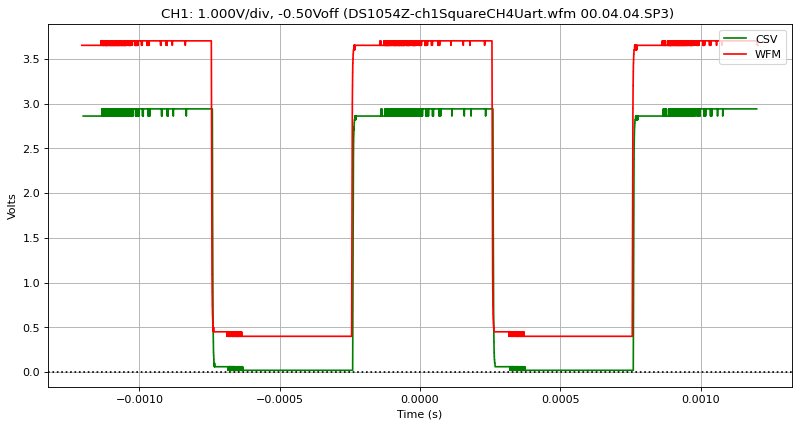

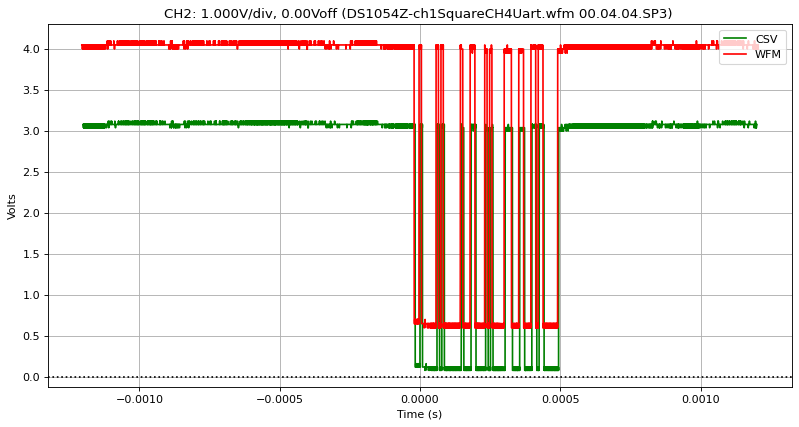

In [25]:
name = "DS1054Z-ch1SquareCH4Uart"
wfm_url = repo + name + ".wfm" + "?raw=true"  
w = rigol.Wfm.from_url(wfm_url, '1000Z')

csv_filename = repo + name + ".csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2)
csv_data = csv_data[:,:-1].T

t_incr = 4.000000e-08    # seconds/point
t_start = -len(csv_data[0])/2.0 * t_incr    # seconds so that t=0 is in the center
csv_times = csv_data[0] * t_incr + t_start   # seconds

plot_compare(w, csv_times, csv_data, toffset=0)

In [26]:
print(w.describe())

    General:
        File Model   = wfm1000z
        User Model   = 1000Z
        Parser Model = wfm1000z
        Firmware     = 00.04.04.SP3
        Filename     = DS1054Z-ch1SquareCH4Uart.wfm
        Channels     = [1, 4]

     Channel 1:
         Coupling =       DC
            Scale =     1.00  V/div
           Offset =  -500.00 mV
            Probe =      10X
         Inverted =    False

        Time Base =  200.000 µs/div
           Offset =    0.000  s
            Delta =   40.000 ns/point
           Points =    60256

         Count    = [        1,        2,        3  ...     60255,    60256]
           Raw    = [      170,      170,      170  ...       170,      170]
           Times  = [-1.205 ms,-1.205 ms,-1.205 ms  ...  1.205 ms, 1.205 ms]
           Volts  = [  3.65  V,  3.65  V,  3.65  V  ...   3.65  V,  3.65  V]

     Channel 4:
         Coupling =       DC
            Scale =     1.00  V/div
           Offset =     0.00  V
            Probe =      10X
         Inverte

In [28]:
name = "/Users/prahl/Desktop/NewFile1.wfm"
w = rigol.Wfm.from_file(name, 'Z')

print(w.describe())

csv_filename = repo + name + ".csv"
csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2)
csv_data = csv_data[:,:-1].T

# this .csv file has the last 250000 points removed
t_incr = 4.000000e-9    # seconds/point
t_start = -len(csv_data[0])/2.0 * t_incr    # seconds so that t=0 is in the center
csv_times = csv_data[0] * t_incr + t_start   # seconds

    General:
        File Model   = wfm1000z
        User Model   = Z
        Parser Model = wfm1000z
        Firmware     = 00.04.04.SP4
        Filename     = NewFile1.wfm
        Channels     = [1]

     Channel 1:
         Coupling =       DC
            Scale =     2.00 mV/div
           Offset =   -25.52 mV
            Probe =       1X
         Inverted =    False

        Time Base =  200.000 µs/div
           Offset =  620.000 µs
            Delta =    2.000 ns/point
           Points =  2400512

         Count    = [        1,        2,        3  ...   2400511,  2400512]
           Raw    = [       53,       49,       53  ...        89,       36]
           Times  = [-1.781 ms,-1.781 ms,-1.781 ms  ...  3.021 ms, 3.021 ms]
           Volts  = [ 20.12 mV, 19.72 mV, 20.12 mV  ...  23.72 mV, 18.42 mV]




OSError: https://github.com/scottprahl/RigolWFM/raw/master/wfm//Users/prahl/Desktop/NewFile1.wfm.csv not found.